In [3]:
import os
import gc

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import numpy.ma as ma

from hbmep.config import Config
from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    DATA_PATH,
    TOML_PATH
)

import math

In [4]:
df = pd.read_csv("/home/andres/data/hbmep-processed/L_CIRC/data.csv")
config = Config(toml_path=TOML_PATH)
model = NonHierarchicalBayesianModel(config=config)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
combination = pickle.load(open("/home/andres/repos/rat-mapping-paper/reports/L_CIRC/combine.pkl", "rb"))

In [6]:
subjects = sorted(df['participant'].unique())
configuration = ['Vertex', 'Radius', 'Diameter']
electrodes = sorted(df['compound_position'].unique())
muscles = model.response

In [7]:
vertices = [e for e in electrodes if e.split('-')[0] == '']

radii = [e for e in electrodes if e.split('-')[1] == 'C6LC' and e != '-C6LC']


diameters = set(electrodes) - (set(vertices) | set(radii))
diameters = list(diameters)


In [10]:
def curve_parameters(
    named_param=None
):
    arr = []
    mask = []

    for sub in subjects:
        for config in configuration:
            for elec in electrodes:
                for m in muscles:
                    flag = False

                    if config == 'Vertex' and elec in vertices:
                        flag = True
                    elif config == 'Radius' and elec in radii:
                        flag = True
                    elif config == 'Diameter' and elec in diameters:
                        flag = True
                    else:
                        flag = False
                    
                    if flag:
                        position = elec
                        key = (sub, position, m)
                        tcomb = combination[key][named_param]
                        tcomb = tcomb.reshape(-1, 1)

                        arr.append(tcomb)
                        mask.append(np.full((4000,1), False))

                    else:
                        arr.append(np.zeros(4000).reshape(-1, 1))
                        mask.append(np.full((4000, 1), True))     

    param = np.array(arr)
    param = param.reshape(len(subjects), len(configuration),len(electrodes), len(muscles), *param.shape[1:])
    mask = np.array(mask)
    mask = mask.reshape(len(subjects), len(configuration),len(electrodes),len(muscles), *mask.shape[1:])

    param = ma.masked_array(param, mask=mask)
    param = param[..., 0]
    return param

In [50]:
a = curve_parameters(named_param='a')
a = a / ma.median(a, axis=(1, 2, 3), keepdims=True)
a.shape

conf_ind = 2

arr_responses = a[:,conf_ind,:,:,:]

In [52]:
arr_responses.shape

(8, 21, 6, 4000)

In [9]:
area_list = []
for subject_ind, subject in enumerate(subjects):

    for cpos_ind in range(len(arr_responses[0,:,0,0])):
        cpos = df['compound_positions'][configuration[cpos_ind]]
        x_temp = x[subject_ind, 0, ...].tolist()
        
        sample_integrals = entropy[subject_ind, cpos_ind, :, :]
        sample_integrals_mean = sample_integrals.mean(axis=0)
        
        area = np.trapz(sample_integrals_mean, x_temp)
        area_list.append((subject, cpos, area))




KeyError: 'compound_positions'

## PLOT

In [10]:
with open("means.pkl", "rb") as f:
    sens_means = pickle.load(f)

eff_sens = []
for c in sens_means:
    for s in save_means:
        if c[0] == s[0]:
            eff_sens.append((c[0], s[1], c[1]))

eff_vals = list(e[1] for e in eff_sens)
sens_vals = list(e[2] for e in eff_sens)
labs = list(e[0] for e in eff_sens)
ax = sns.scatterplot(eff_vals, sens_vals, hue = labs, legend=False)
ax.set(xlabel='Threshold', ylabel='Sensitivity (AUC for entropy)')
plt.show

for i in range(len(eff_vals)):
    plt.text(eff_vals[i] + 0.1, sens_vals[i], labs[i], fontsize=9, ha='left')
    
sns.despine()


NameError: name 'save_means' is not defined

In [10]:
def get_pvalues(ind):
    pvalues = []
    mask = []
    data = []
    means =[]
    labels = []
    global electrodes

    orientation_ind = ind
    
    if orientation_ind == 0:
        target_electrodes = list(s for s in electrodes if s.split("-")[0] == "")
    if orientation_ind == 1:
        target_electrodes = list(s for s in electrodes if s.split("-")[1] == "C6LC" and s.split("-")[0] != "")
    if orientation_ind == 2:
        target_electrodes = list(s for s in electrodes if s.split("-")[0] != "" and s.split("-")[1] != "C6LC")
                        
    for l_electrode_ind, l_electrode in enumerate(electrodes):
        for r_electrode_ind, r_electrode in enumerate(electrodes):
            if (l_electrode == r_electrode):
                pvalues.append(1)
                data.append(l_electrode)
                means.append(0)
                if l_electrode in target_electrodes:
                    mask.append(False)
                else:  
                    mask.append(True)
                    continue
                continue

            l_samples = a[:, orientation_ind,l_electrode_ind,...]  # sub, seg, muscle, # posterior_samples
            r_samples = a[:, orientation_ind,r_electrode_ind,...] 
            
            t = l_samples.mean(axis=-1) - r_samples.mean(axis=-1)

            ttest = stats.ttest_1samp(
                t, popmean=0, alternative="two-sided", axis=(0, 1)
            )

            pvalues.append(ttest.pvalue)
            ci = ttest.confidence_interval(.95)

            t = l_samples - r_samples # sub, seg, muscle, # posterior_samples
            data.append(
                f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
            )
            means.append(t.mean())
            
            if math.isnan(t.mean()):
                mask.append(True)

            else:
                mask.append(False)
                if l_electrode not in labels:
                    label = f"{l_electrode}"
                    labels.append(label)
                                
    mask = np.array(mask)
    mask = mask.reshape(21, 21)
    
    pvalues = np.array(pvalues)
    pvalues = pvalues.reshape(21, 21)
    pvalues = pvalues[~mask]
    pvalues = pvalues.reshape(len(target_electrodes), len(target_electrodes))

    data = np.array(data)
    data = data.reshape(21, 21)
    data = data[~mask]
    data = data.reshape(len(target_electrodes), len(target_electrodes))
    
    means = np.array(means)
    means = means.reshape(21, 21)
    means = means[~mask]
    means = means.reshape(len(target_electrodes), len(target_electrodes))

    mask2= mask
    mask2 = mask2[~mask]
    mask2 = mask2.reshape(len(target_electrodes),len(target_electrodes))
    mask2 = np.tril(np.ones_like(mask2), k=-1)

    plt.figure(figsize=(15, 5))
    handles = []
    ax=sns.heatmap(means, xticklabels=labels, yticklabels=labels, annot=data, fmt= "", mask =mask2,cbar = False,center = 0, cmap = "coolwarm")
    plt.xticks(rotation=45);
    hatch_mask = pvalues > 0.05

    for i in range (pvalues.shape[0]):
        for j in range(pvalues.shape[1]):
            if hatch_mask[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                        hatch='', label="Significant"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                        hatch='////', label="Not Significant"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                        hatch='', label="Row Element Lower Threshold"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                        hatch='', label="Row Element Higher Threshold"))
    ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
            handlelength=2, handleheight=2, frameon=False)
    ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

    ax.yaxis.tick_right()
    plt.show()

/home/andres/repos/rat-mapping-paper/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/andres/repos/rat-mapping-paper/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1051897/3767225211.py:45: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
/tmp/ipykernel_1051897/3767225211.py:49: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(t.mean()):
/tmp/ipykernel_1051897/3767225211.py:71: UserWarning: Warning: converting a masked element to nan.
  means = np.array(means)


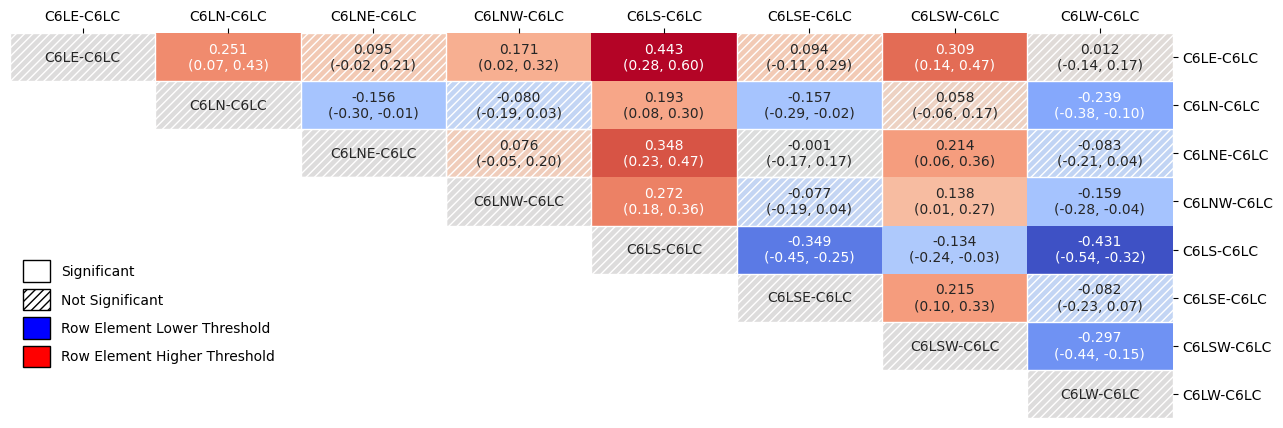

In [11]:
get_pvalues(1)

In [12]:
def get_ind_muscles(ind, m_ind):
    pvalues = []
    mask = []
    data = []
    means =[]
    labels = []
    global electrodes
    global model

    orientation_ind = ind
    
    if orientation_ind == 0:
        target_electrodes = list(s for s in electrodes if s.split("-")[0] == "")
    if orientation_ind == 1:
        target_electrodes = list(s for s in electrodes if s.split("-")[1] == "C6LC" and s.split("-")[0] != "")
    if orientation_ind == 2:
        target_electrodes = list(s for s in electrodes if s.split("-")[0] != "" and s.split("-")[1] != "C6LC")
                        
    for l_electrode_ind, l_electrode in enumerate(electrodes):
        for r_electrode_ind, r_electrode in enumerate(electrodes):
            if (l_electrode == r_electrode):
                pvalues.append(1)
                data.append(l_electrode)
                means.append(0)
                if l_electrode in target_electrodes:
                    mask.append(False)
                else:  
                    mask.append(True)
                    continue
                continue

            l_samples = a[:, orientation_ind,l_electrode_ind,m_ind,...]  # sub, seg, muscle, # posterior_samples
            r_samples = a[:, orientation_ind,r_electrode_ind,m_ind,...] 
            
            t = l_samples.mean(axis=-1) - r_samples.mean(axis=-1)

            ttest = stats.ttest_1samp(
                t, popmean=0, alternative="two-sided", axis=(0)
            )

            pvalues.append(ttest.pvalue)
            ci = ttest.confidence_interval(.95)

            t = l_samples - r_samples # sub, seg, muscle, # posterior_samples
            data.append(
                f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
            )
            means.append(t.mean())
            
            if math.isnan(t.mean()):
                mask.append(True)

            else:
                mask.append(False)
                if l_electrode not in labels:
                    label = f"{l_electrode}"
                    labels.append(label)
                                
    mask = np.array(mask)
    mask = mask.reshape(21, 21)
    
    pvalues = np.array(pvalues)
    pvalues = pvalues.reshape(21, 21)
    pvalues = pvalues[~mask]
    pvalues = pvalues.reshape(len(target_electrodes), len(target_electrodes))

    data = np.array(data)
    data = data.reshape(21, 21)
    data = data[~mask]
    data = data.reshape(len(target_electrodes), len(target_electrodes))
    
    means = np.array(means)
    means = means.reshape(21, 21)
    means = means[~mask]
    means = means.reshape(len(target_electrodes), len(target_electrodes))

    mask2= mask
    mask2 = mask2[~mask]
    mask2 = mask2.reshape(len(target_electrodes),len(target_electrodes))
    mask2 = np.tril(np.ones_like(mask2), k=-1)

    fig, ax = plt.subplots(nrows = 1, ncols = 6)
    plt.figure(figsize=(15, 5))
    handles = []
    ax=sns.heatmap(means, xticklabels=labels, yticklabels=labels, annot=data, fmt= "", mask =mask2,cbar = False,center = 0, cmap = "coolwarm")
    plt.xticks(rotation=45);
    hatch_mask = pvalues > 0.05

    for i in range (pvalues.shape[0]):
        for j in range(pvalues.shape[1]):
            if hatch_mask[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                        hatch='', label="Significant"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                        hatch='////', label="Not Significant"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                        hatch='', label="Row Element Lower Threshold"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                        hatch='', label="Row Element Higher Threshold"))
    ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
            handlelength=2, handleheight=2, frameon=False)
    ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

    ax.yaxis.tick_right()
    plt.title(f"Muscle: {model.response[m_ind]}")
    plt.show()

/tmp/ipykernel_1012418/3767225211.py:45: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
/tmp/ipykernel_1012418/3767225211.py:49: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(t.mean()):
/tmp/ipykernel_1012418/3767225211.py:71: UserWarning: Warning: converting a masked element to nan.
  means = np.array(means)


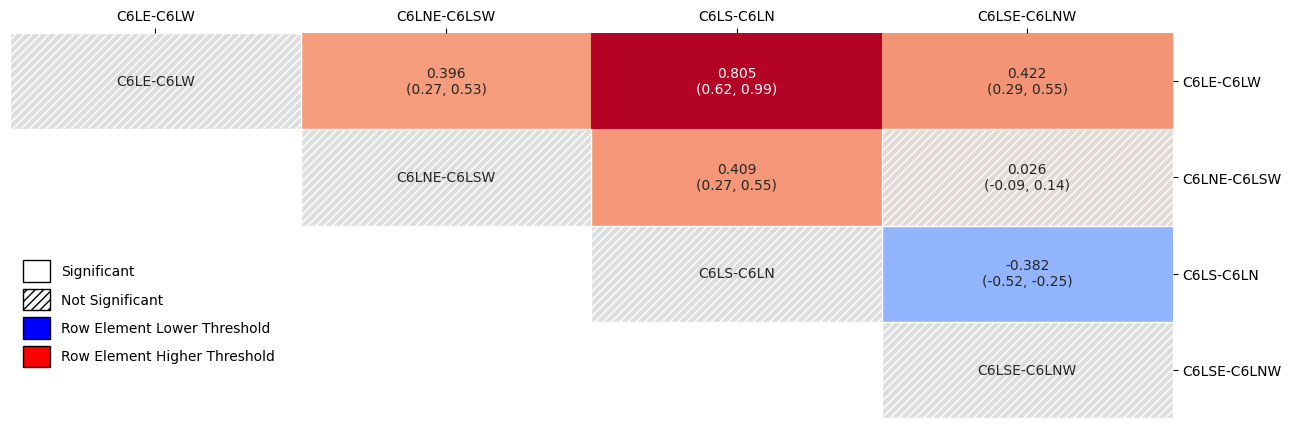

In [14]:
get_pvalues(2)

/tmp/ipykernel_1012418/4011826639.py:46: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
/tmp/ipykernel_1012418/4011826639.py:50: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(t.mean()):
/tmp/ipykernel_1012418/4011826639.py:72: UserWarning: Warning: converting a masked element to nan.
  means = np.array(means)


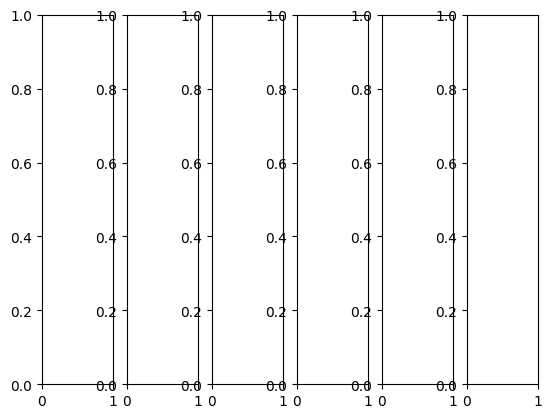

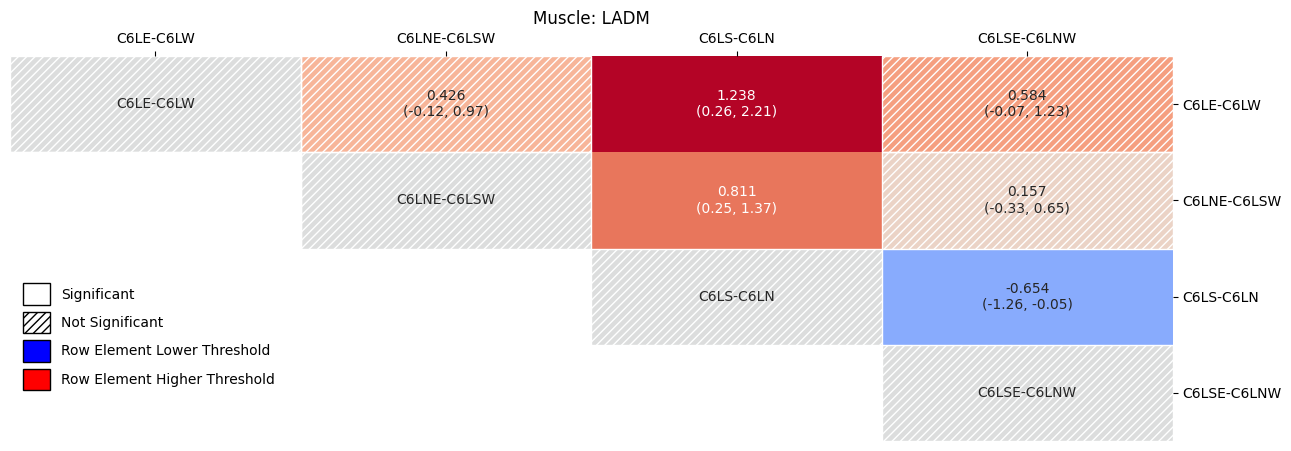

In [15]:
get_ind_muscles(2, 0)


In [16]:
a.shape
arr_responses.shape

(8, 21, 6, 4000)

In [17]:
arr_responses.mask[:,10,:,:].all()

False

In [127]:
from matplotlib import patches

In [13]:
src = os.path.join("/home/andres/repos/rat-mapping-paper/reports/L_CIRC/predictions.pkl")

with open(src, "rb") as f:
    x, _, subjects, compound_positions, configurations, response, = pickle.load(f)

# FIX TO MAKE CONNECTIONS

In [132]:
# #   # Check for significance and store pairs
#                 if eff_temp > some_significance_threshold:  # Replace with your significance logic
#                     significant_pairs.append((bubble_rads[i], i))

#         stop = len(filt_positions)
#         ax[musc].set_xticks(bubble_rads[0:stop], list((z[1] for z in mean_list[0:stop])))
#         ax[musc].set_yticklabels([])
#         ax[musc].yaxis.set_visible(False)
#         if ind == 0:
#             ax[musc].text(0, 0, 'C6LC', horizontalalignment='center', verticalalignment='center')
#         ax[musc].set_title(f"Mean Threshold for each position, individual rat, muscle: {model.response[musc]} \n Smaller = more effective")

#         # Add CIRCOS plot connections
#         for rad1, rad2 in significant_pairs:
#             ax[musc].add_patch(patches.ConnectionPatch((rad1, 10), (rad2, 10), "data", "data", color="red", alpha=0.5))

#     fig.show()

def bubble_plot(ind, musc):

    global compound_positions
    a = curve_parameters(named_param='a')
    a = a / ma.median(a, axis=(1, 2, 3), keepdims=True)
    if musc == 6:
        muscle = "All"
        col = "black"
    else:
        muscle = model.response[musc]
        col = model._get_colors(model.n_response)[musc]
    
    angles_key = ['nan', 90, 0, 45, 315, 180, 135, 225, 270, 90, 90, 0, 45, 45, 315, 180, 180, 135, 135, 225, 270]
    color_dict = {
        '-C6LC': '#1f77b4',
        '-C6LE': '#ff7f0e',
        '-C6LN': '#2ca02c',
        '-C6LNE': '#d62728',
        '-C6LNW': '#9467bd',
        '-C6LS': '#8c564b',
        '-C6LSE': '#e377c2',
        '-C6LSW': '#7f7f7f',
        '-C6LW': '#bcbd22',
        'C6LE-C6LC': '#17becf',
        'C6LE-C6LW': '#aec7e8',
        'C6LN-C6LC': '#ffbb78',
        'C6LNE-C6LC': '#98df8a',
        'C6LNE-C6LSW': '#ff9896',
        'C6LNW-C6LC': '#c5b0d5',
        'C6LS-C6LC': '#c49c94',
        'C6LS-C6LN': '#f7b6d2',
        'C6LSE-C6LC': '#c7c7c7',
        'C6LSE-C6LNW': '#dbdb8d',
        'C6LSW-C6LC': '#9edae5',
        'C6LW-C6LC': '#fdfd96'
    }
    conf_ind = ind
    mean_list = []
    
    significant_pairs = []
    
    pvals = [] 
    
    if musc == 6:
        arr_responses = a[:,conf_ind,:,:,:]
        
        
        for sub_ind, s in enumerate(subjects):
            for c_ind, c in enumerate(arr_responses[0,:,0,0]):
                if arr_responses.mask[sub_ind,c_ind,:,:].all():
                    continue
                
                mean_list.append((subjects[sub_ind], compound_positions[c_ind], arr_responses[sub_ind,c_ind,:,:].mean()))
                
                for c2_ind, c2 in enumerate(arr_responses[0,:,0,0]):
                    if c == c2:
                        continue
                    s1 = arr_responses[sub_ind, c_ind, :, :]
                    s2 = arr_responses[sub_ind, c2_ind, :, :]
                    
                    ttest = stats.ttest_rel(s1, s2, alternative='two-sided')
                    pvals.append((c_ind, c2_ind, ttest.pvalue))

    else:
        arr_responses = a[:,conf_ind,:,musc,:]
        
        for sub_ind, s in enumerate(subjects):
            for c_ind, c in enumerate(arr_responses[0,:,0]):
                if arr_responses.mask[sub_ind,c_ind,:].all():
                    continue
                
                mean_list.append((subjects[sub_ind], compound_positions[c_ind], arr_responses[sub_ind,c_ind,:].mean()))

    filt_positions = list(set((z[1] for z in mean_list)))

    bubble_rads = [] 
    for z in (mean_list):
        if z[1] == '-C6LC':
            bubble_rads.append(0)
        else:
            bubble_rads.append(np.radians(angles_key[compound_positions.index(z[1])]))
            
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    min_mean = min((z[2] for z in mean_list))    
    
    # cols = cols.reshape(-1)
    for i, z in enumerate(mean_list):
        # ax.text(bubble_rads[i], .5, label, horizontalalignment='center', verticalalignment='center')
        
        if z[1] == '-C6LC':
            eff_temp = (mean_list[i][2]-min_mean)
            ax.scatter(0, 0,  #x = angle, y = radius
                    s=(eff_temp)*5000, alpha=0.1, color = col, edgecolors='black')
        else:
            eff_temp = ((mean_list[i][2]-min_mean))
            if eff_temp == 0:
                ax.scatter(bubble_rads[i], 10,  #x = angle, y = radius
                        s=(min_mean*5000), alpha=0.1, color = col, edgecolors='black')
            else:
                ax.scatter(bubble_rads[i], 10,  #x = angle, y = radius
                            s=(eff_temp*5000), alpha=0.1, color = col, edgecolors='black')

    stop = len(filt_positions)
    plt.xticks(bubble_rads[0:stop], list((z[1] for z in mean_list[0:stop])))  
    ax.set_yticklabels([])
    ax.yaxis.set_visible(False)
    fig.title = "Threshold for each position, individual rat"
    if ind == 0:
        plt.text(0, 0, 'C6LC', horizontalalignment='center', verticalalignment='center')

    fig.show()
    ax.set_title(f"Mean Threshold for each position, individual rat, muscle: {muscle} \n Smaller = more effective" )
    
    return pvals, mean_list
    

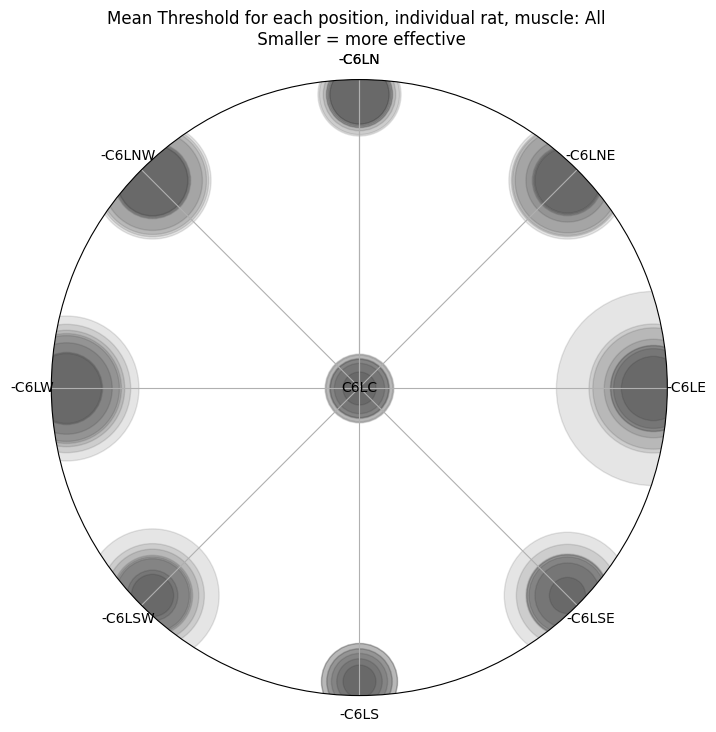

In [136]:
p, m = bubble_plot(0, 6)

In [138]:
p

[(0,
  1,
  array([1.56447326e-03, 1.60586858e-03, 1.32784678e-03, ...,
         1.38195600e-07, 1.73057030e-04, 4.49937806e-06])),
 (0,
  2,
  array([0.17606146, 0.21675092, 0.23263963, ..., 0.12712724, 0.08281747,
         0.08343728])),
 (0,
  3,
  array([0.00066572, 0.00119238, 0.0011614 , ..., 0.00076027, 0.00053598,
         0.00051485])),
 (0,
  4,
  array([0.00725367, 0.03459486, 0.03286067, ..., 0.02351859, 0.01062259,
         0.01728338])),
 (0,
  5,
  array([0.09988057, 0.13198307, 0.146495  , ..., 0.05013437, 0.0564332 ,
         0.08837403])),
 (0,
  6,
  array([1.81713036e-04, 3.20755792e-04, 5.05889691e-05, ...,
         7.67434657e-04, 5.01375290e-05, 5.83639999e-05])),
 (0,
  7,
  array([0.02111582, 0.03213734, 0.02710755, ..., 0.01552843, 0.01324098,
         0.01378235])),
 (0,
  8,
  array([0.03587169, 0.02688113, 0.01981749, ..., 0.02923429, 0.02718719,
         0.02103205])),
 (0, 9, array([nan, nan, nan, ..., nan, nan, nan])),
 (0, 10, array([nan, nan, nan, ...,

In [125]:
def all_together_bubble_plot(ind):

    global compound_positions
    a = curve_parameters(named_param='a')
    a = a / ma.median(a, axis=(1, 2, 3), keepdims=True)

    #col = model._get_colors(model.n_response)[musc]
    
    angles_key = ['nan', 90, 0, 45, 315, 180, 135, 225, 270, 90, 90, 0, 45, 45, 315, 180, 180, 135, 135, 225, 270]
    color_dict = {
        '-C6LC': '#1f77b4',
        '-C6LE': '#ff7f0e',
        '-C6LN': '#2ca02c',
        '-C6LNE': '#d62728',
        '-C6LNW': '#9467bd',
        '-C6LS': '#8c564b',
        '-C6LSE': '#e377c2',
        '-C6LSW': '#7f7f7f',
        '-C6LW': '#bcbd22',
        'C6LE-C6LC': '#17becf',
        'C6LE-C6LW': '#aec7e8',
        'C6LN-C6LC': '#ffbb78',
        'C6LNE-C6LC': '#98df8a',
        'C6LNE-C6LSW': '#ff9896',
        'C6LNW-C6LC': '#c5b0d5',
        'C6LS-C6LC': '#c49c94',
        'C6LS-C6LN': '#f7b6d2',
        'C6LSE-C6LC': '#c7c7c7',
        'C6LSE-C6LNW': '#dbdb8d',
        'C6LSW-C6LC': '#9edae5',
        'C6LW-C6LC': '#fdfd96'
    }
    conf_ind = ind
    mean_list = []

    fig, ax = plt.subplots(3, 2, figsize=(30, 30), subplot_kw=dict(polar=True))
    ax = ax.flatten()
    
    significant_pairs = []
    
    for musc in range(model.n_response):
        mean_list = []
        arr_responses = a[:,conf_ind,:,musc,:]

        for sub_ind, s in enumerate(subjects):
            for c_ind, c in enumerate(arr_responses[0,:,0]):
                if arr_responses.mask[sub_ind,c_ind,:].all():
                    continue
                
                mean_list.append((subjects[sub_ind], compound_positions[c_ind], arr_responses[sub_ind,c_ind,:].mean()))

        filt_positions = list(set((z[1] for z in mean_list)))

        bubble_rads = [] 
        
        for z in (mean_list):
            if z[1] == '-C6LC':
                bubble_rads.append(0)
            else:
                bubble_rads.append(np.radians(angles_key[compound_positions.index(z[1])]))
            
        
        ax[musc].set_theta_offset(np.pi / 2)
        ax[musc].set_theta_direction(-1)
        
        min_mean = min((z[2] for z in mean_list))    
        
        # cols = cols.reshape(-1)
        for i, z in enumerate(mean_list):
            # ax.text(bubble_rads[i], .5, label, horizontalalignment='center', verticalalignment='center')
            if z[1] == '-C6LC':
                eff_temp = (mean_list[i][2]-min_mean)
                ax[musc].scatter(0, 0,  #x = angle, y = radius
                        s=(eff_temp)*5000, alpha=0.1, color = model._get_colors(model.n_response)[musc], edgecolors='black')
            else:
                eff_temp = ((mean_list[i][2]-min_mean))
                if eff_temp == 0:
                    ax[musc].scatter(bubble_rads[i], 10,  #x = angle, y = radius
                            s=(min_mean*5000), alpha=0.1, color = model._get_colors(model.n_response)[musc], edgecolors='black')
                else:
                    ax[musc].scatter(bubble_rads[i], 10,  #x = angle, y = radius
                                s=(eff_temp*5000), alpha=0.1, color = model._get_colors(model.n_response)[musc], edgecolors='black')

        stop = len(filt_positions)
        ax[musc].set_xticks(bubble_rads[0:stop], list((z[1] for z in mean_list[0:stop])))  
        ax[musc].set_yticklabels([])
        ax[musc].yaxis.set_visible(False)
        if ind == 0:
            ax[musc].text(0, 0, 'C6LC', horizontalalignment='center', verticalalignment='center')
        ax[musc].set_title(f"Mean Threshold for each position, individual rat, muscle: {model.response[musc]} \n Smaller = more effective" )
    

    fig.show()
    # ax[musc].set_title(f"Mean Threshold for each position, individual rat, muscle: {model.response(musc)} \n Smaller = more effective" )

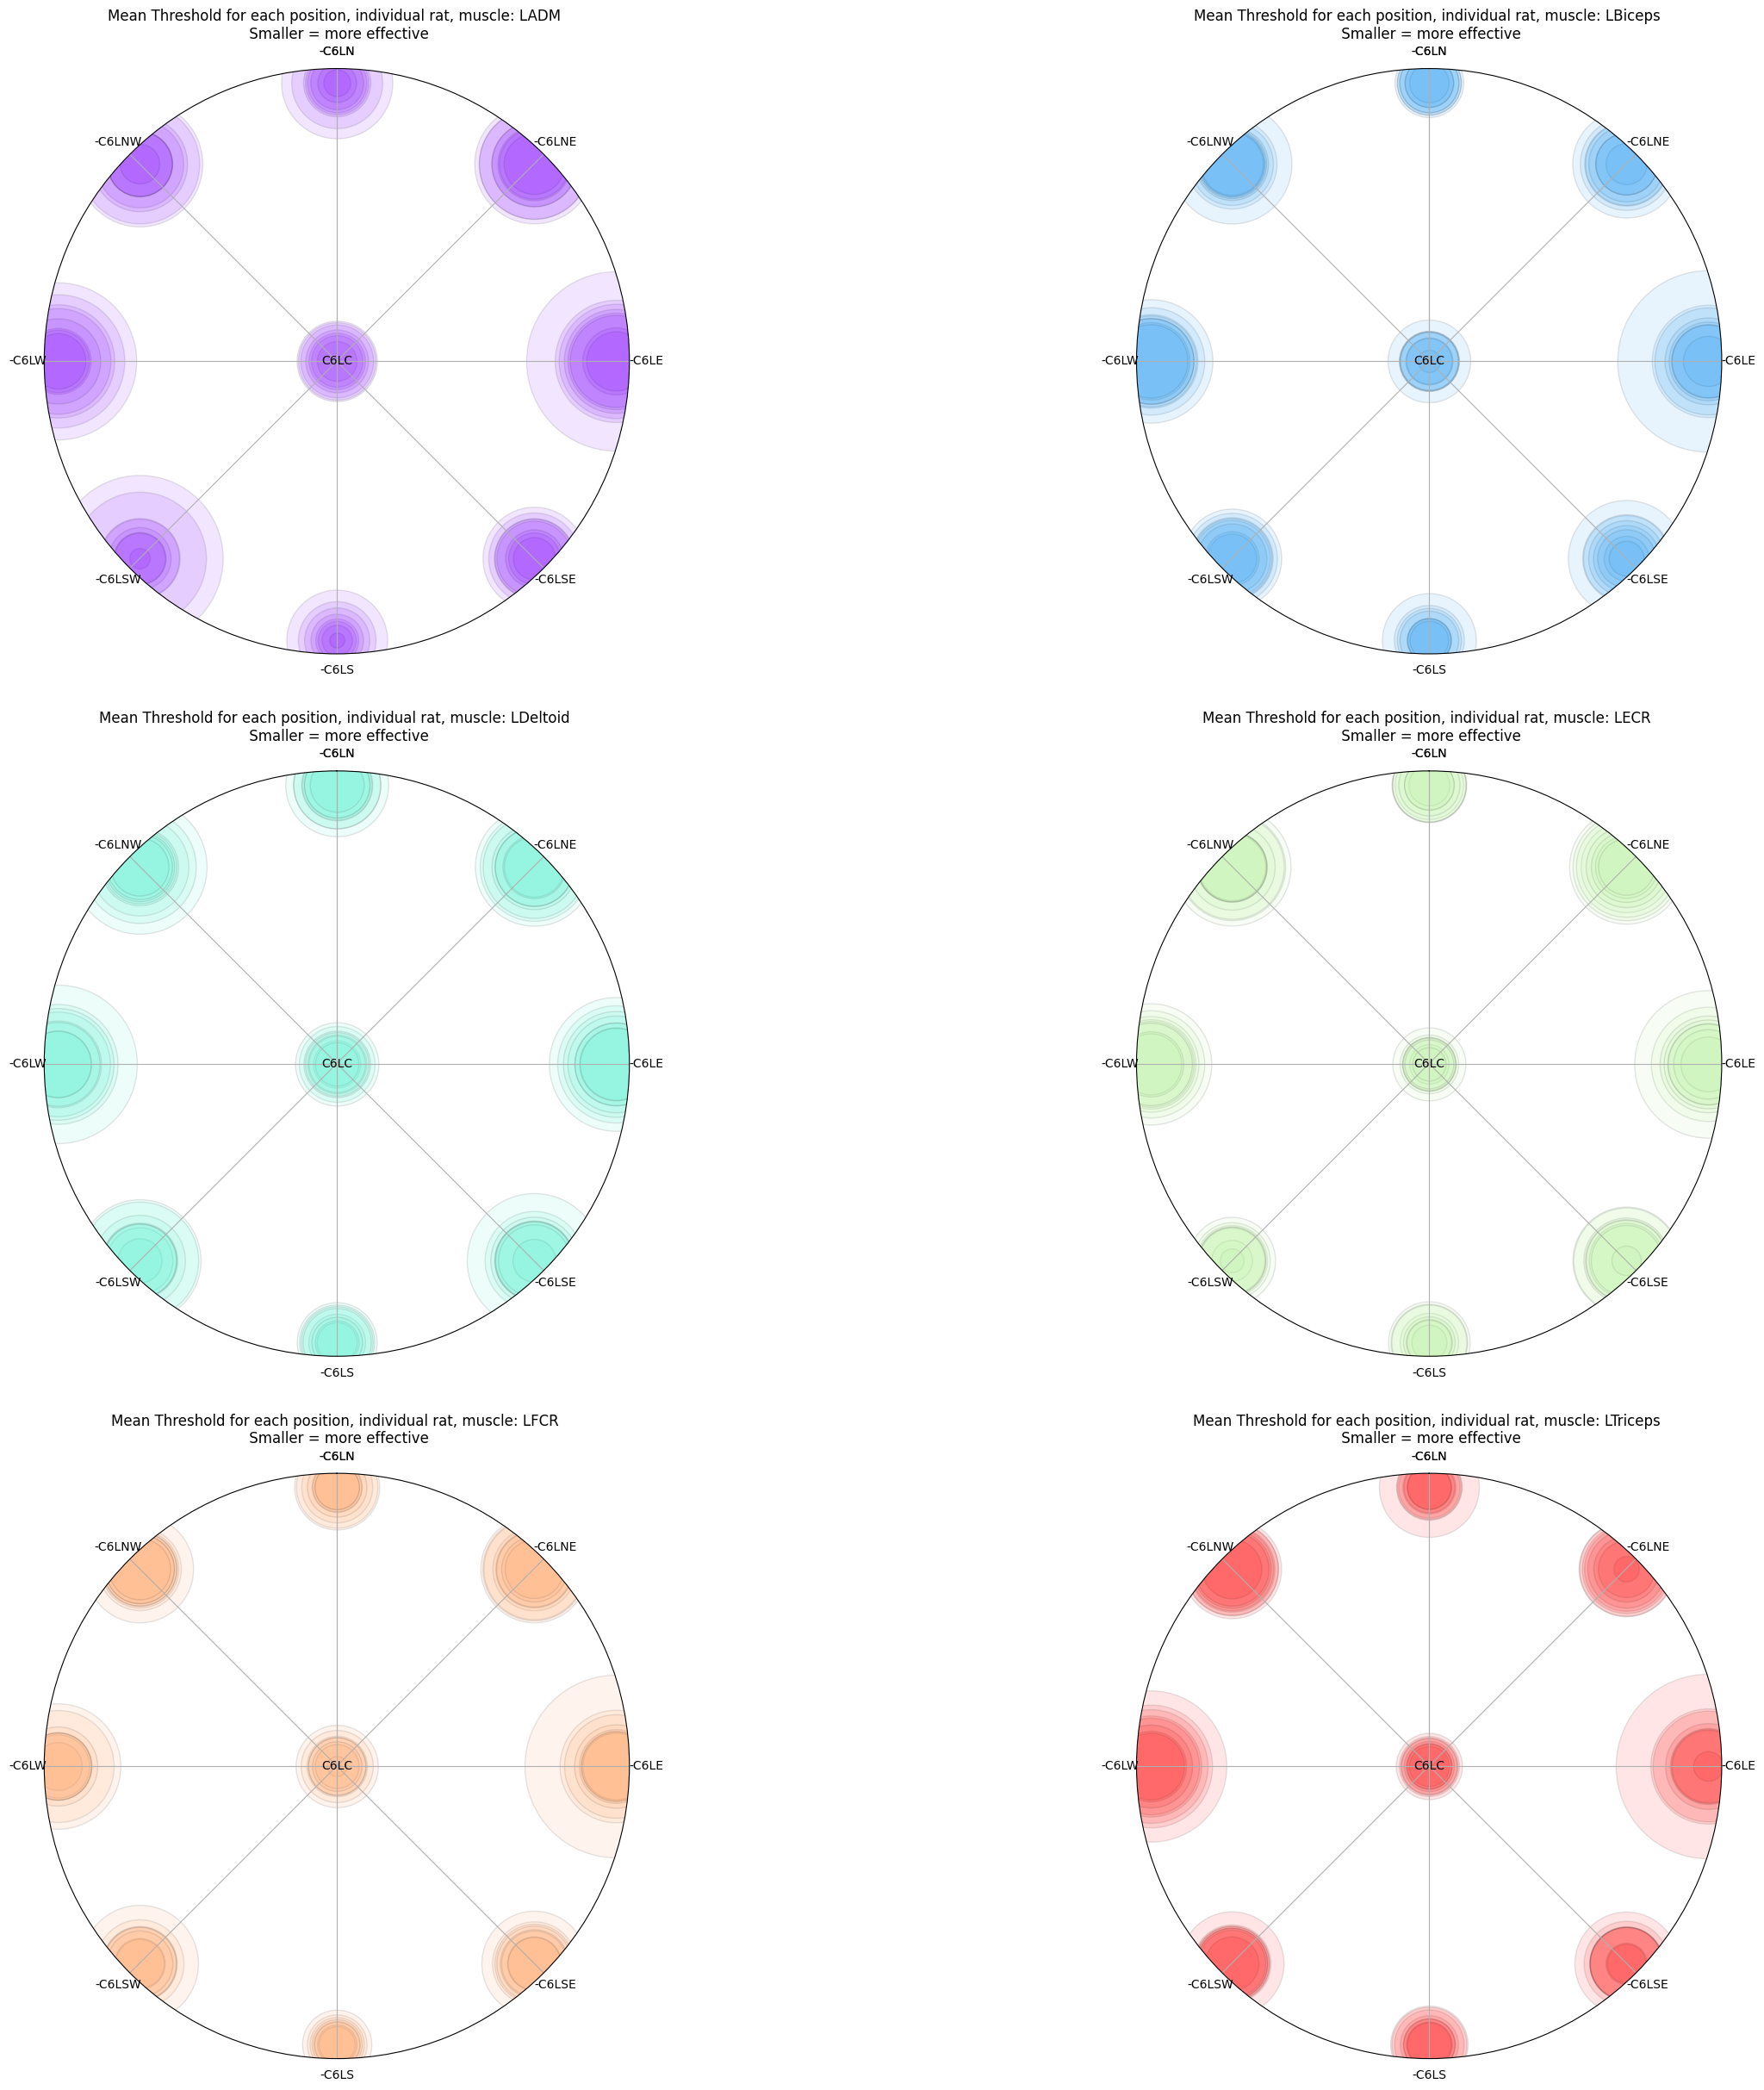

In [126]:
all_together_bubble_plot(0)